In [1]:
from display import display_figures
from display.display_figures_by_county import display_connect_structure, display_spatCorrLevels, display_spatCorr_onR
from display.display_figures_by_county import display_comparison_uni_multi, display_comparison_error_uni_multi


from include.build_synth import buildData_fromRO as build
from include.build_synth import load_RO as load

from include.build_synth.Tikhonov_method import Tikhonov_spat_corr_config
from include.build_synth.compute_spatCorrLevels import compute_spatCorrLevels

from include.estim.Rt_Univariate import Rt_U
from include.estim.Rt_Multivariate import Rt_M

from include.load_data.get_counts import get_real_counts, get_real_counts_by_county


from include.estim.Rt_UnivariateOutliers import Rt_U_O
from include.estim.Rt_Multivariate import Rt_M

import matplotlib.pyplot as plt

In [2]:
import pandas as pd
import numpy as np

def random_fl_days(dataBasis, ndays=150):
    if dataBasis=="JHU":
        datemin, datemax = pd.to_datetime("2020-03-23"), pd.to_datetime("2023-03-09")
    elif dataBasis=="SPF":
        datemin, datemax = pd.to_datetime("2020-05-14"), pd.to_datetime("2023-06-27")
    else:
        DataBasisUnknown = ValueError("Data Basis %s unknown." % dataBasis)
        raise DataBasisUnknown
    datemax = datemax - pd.Timedelta(days=ndays-1)
    # get the random first day
    random_days = np.random.randint(0, (datemax - datemin).days + 1)
    firstDay = datemin + pd.Timedelta(days=random_days)
    lastDay = firstDay + pd.Timedelta(days=ndays-1)
    return firstDay.strftime("%Y-%m-%d"), lastDay.strftime("%Y-%m-%d")

def list_available_countries_JHU():
    webdata = pd.read_csv('data/Real-world/JHU-worldwide-covid19-daily-new-infections.csv')
    dataCountries = webdata['Country/Region']
    return list(dataCountries)

c:\Users\adminuser\Documents\GitHub\Covid-R-estim\display\display_figures_by_county.py:33: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


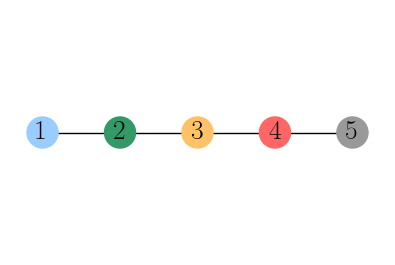

In [3]:
# Choice of connectivity structure and spatial correlation level (configMulti) for multivariate synthetic infection counts
connectStruct = 'Line'
display_connect_structure(connectStruct)

In [4]:
"Thailand" in list_available_countries_JHU()

True

In [5]:
#fix seed for the random dates
np.random.seed(2025)

# Adding inter-county correlations to initial realistic univariate R crafted on each county.
_, _, optionsMulti = load.loadROconfigMulti(connectStruct, '0')

# load RO data from different countries (or counties) and different time period
dataBasis = 'JHU'
ndays = 60
countries = ['France','Pakistan', 'Thailand', 'Canada', 'Austria']

#estimation parameters
lambdaU_L = 3.5
lambdaU_O = 0.03


firstDay, lastDay = random_fl_days(dataBasis, ndays)

ZDataallcounties = np.zeros((5,ndays+1))
for i,country in enumerate(countries):
    # Fetch data and associated dates
    ZData, options = get_real_counts(country, firstDay, lastDay, dataBasis)
    ZDataallcounties[i,:] = ZData
    optionsMulti['firstCases'][i] = ZData[0]
# Estimating R and O with Chambolle-Pock algorithm
R_by_county, O_by_county, options_UO = Rt_U_O(ZDataallcounties, lambdaU_L, lambdaU_O, options=options)


Opening data from Johns Hopkins University.
Opening data from Johns Hopkins University.
Opening data from Johns Hopkins University.
Opening data from Johns Hopkins University.
Opening data from Johns Hopkins University.
Computing Univariate estimation with O misreported counts modelisation ...
Done in 24.8989 seconds ---


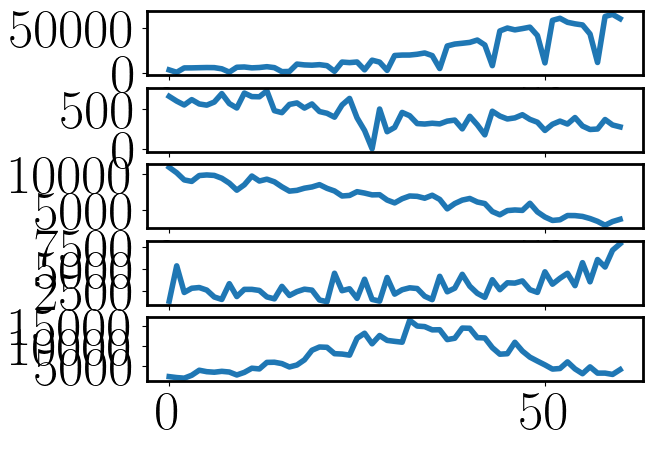

In [6]:
fig, axs = plt.subplots(5,1)
for i, ax in enumerate(axs):
    ax.plot(ZDataallcounties[i,:])

{'firstCases': array([ 3822.,   663., 10863.,  1292.,  2382.]), 'B_matrix': array([[ 1., -1.,  0.,  0.,  0.],
       [-1.,  1.,  0.,  0.,  0.],
       [ 0.,  1., -1.,  0.,  0.],
       [ 0., -1.,  1.,  0.,  0.],
       [ 0.,  0.,  1., -1.,  0.],
       [ 0.,  0., -1.,  1.,  0.],
       [ 0.,  0.,  0.,  1., -1.],
       [ 0.,  0.,  0., -1.,  1.]])}


c:\Users\adminuser\Documents\GitHub\Covid-R-estim\display\display_figures_by_county.py:101: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


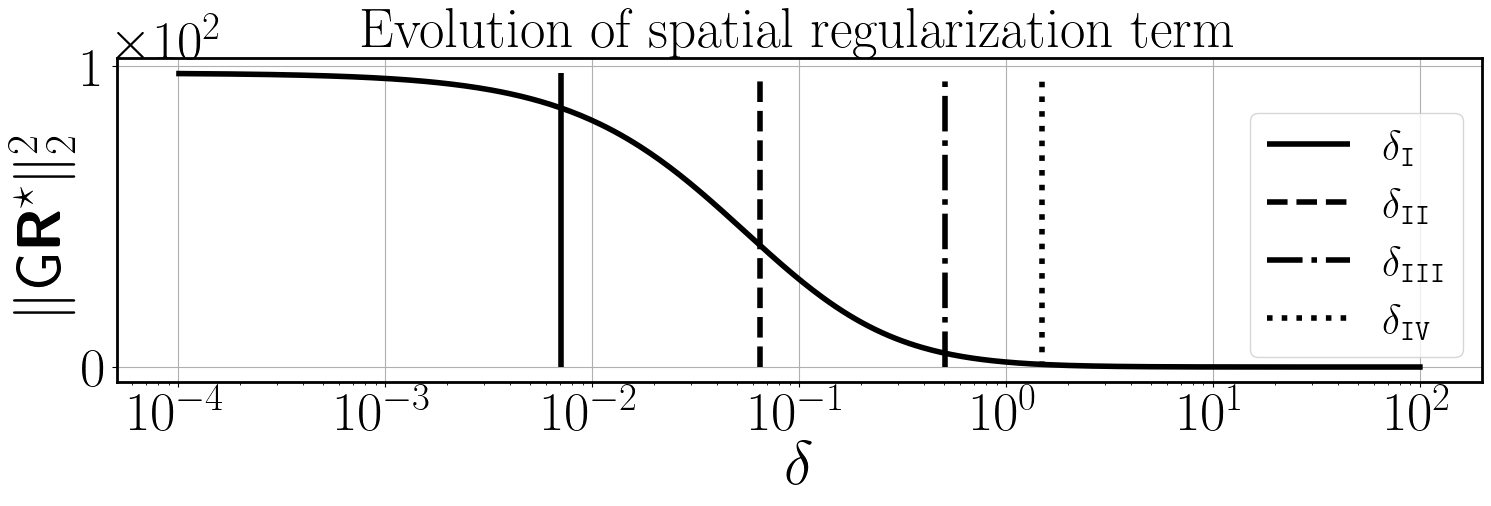

In [7]:
# display_spatCorrLevels(R_by_county, options=optionsMulti, fileSuffix=connectStruct)
optionsDelta = compute_spatCorrLevels(R_by_county, options=optionsMulti, fileSuffix=connectStruct)
print(optionsMulti)
# Inter-county correlation levels computation
display_spatCorrLevels(R_by_county, options=optionsMulti, fileSuffix=connectStruct)

c:\Users\adminuser\Documents\GitHub\Covid-R-estim\display\display_figures.py:370: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


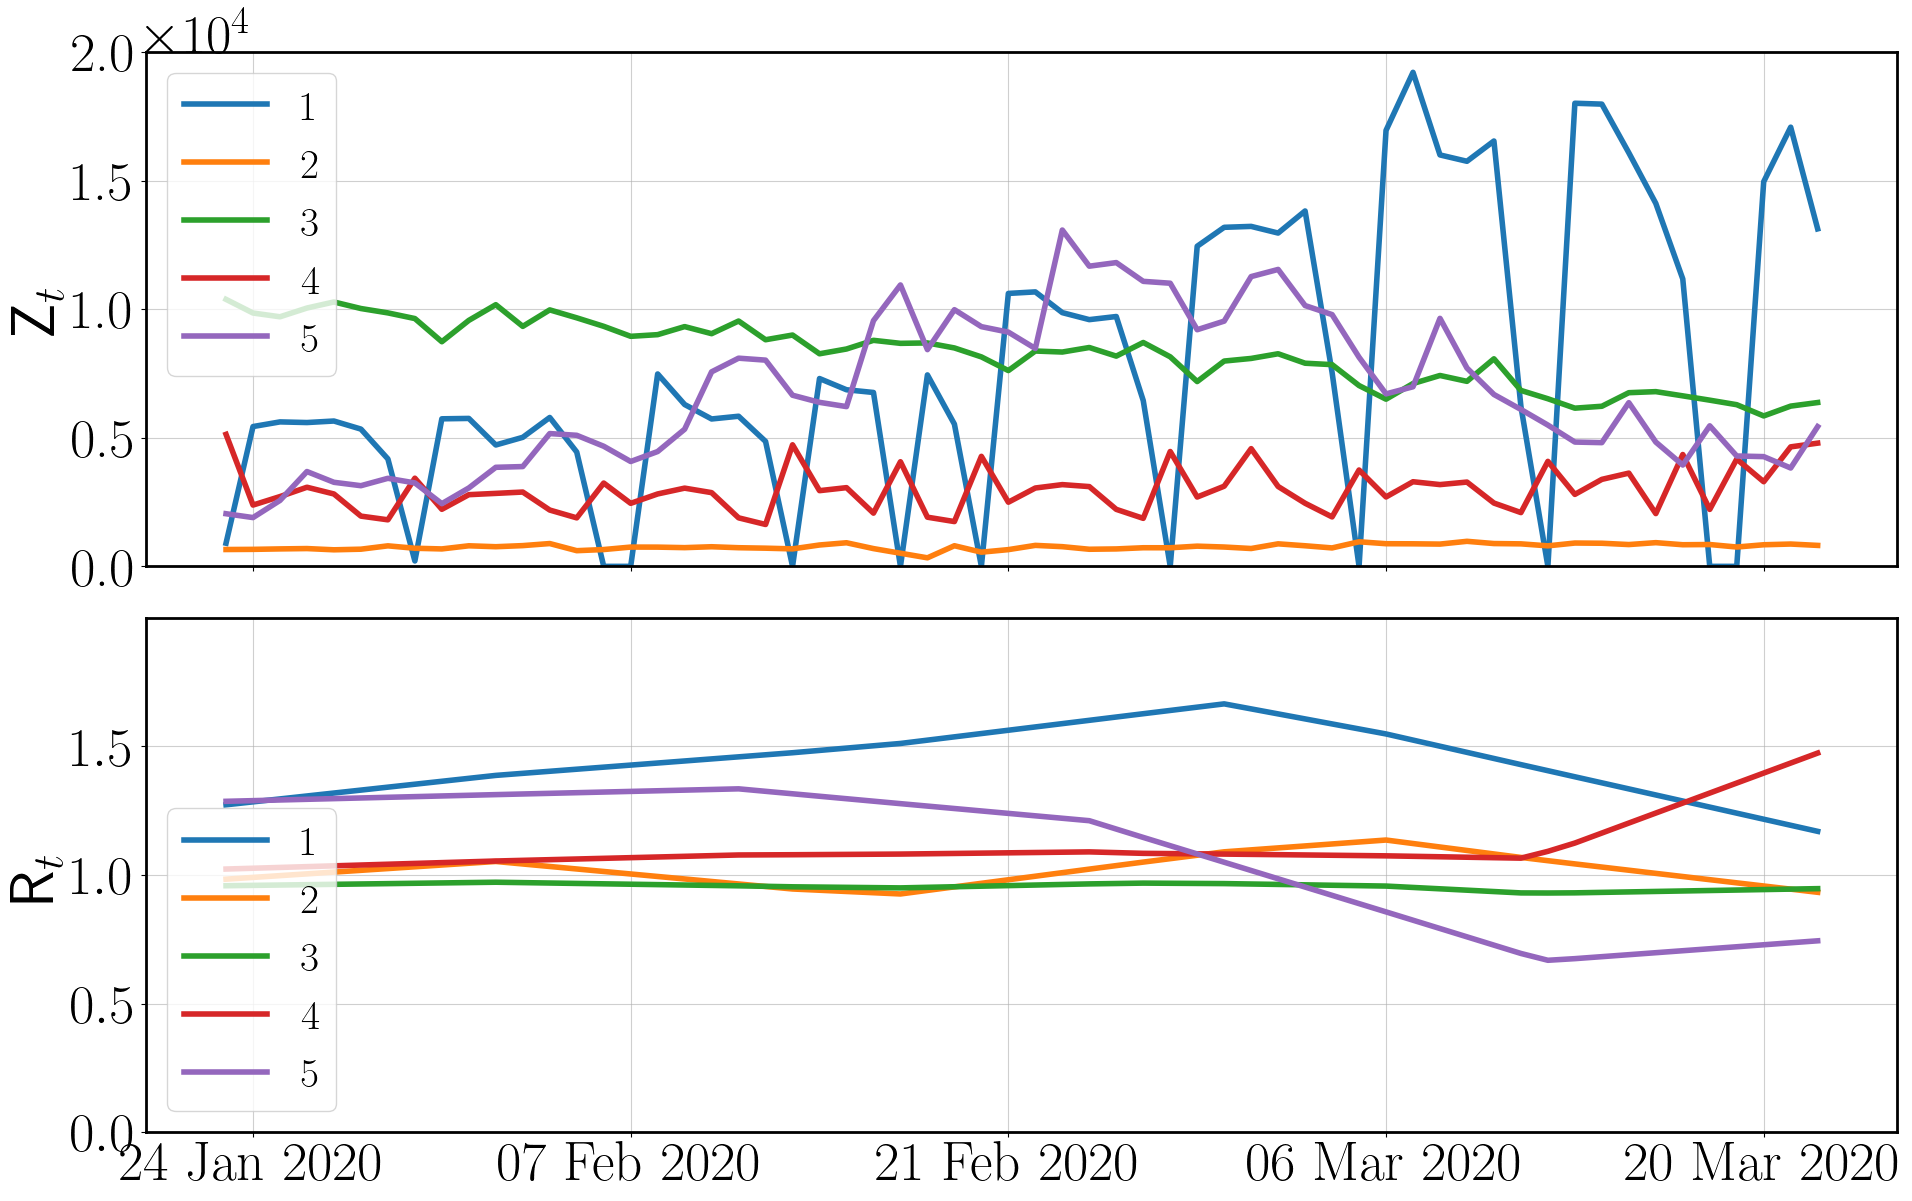

In [8]:
# Adding inter-county correlations to R_by_county (or R dagger)
configMulti = 'II'
R_star = Tikhonov_spat_corr_config(R_by_county, configMulti, optionsDelta)

# Crafting synthetic infection counts using R_star
ZDataBuilt, optionsBuilt = build.buildDataMulti_anyRO(R_star, O_by_county, options=optionsMulti)

fig2D, axes2D, datesBuiltCrop = display_figures.display_REstim_by_county(ZDataBuilt, R_star, optionsBuilt, dataDisp=True)


In [9]:
firstDay, lastDay

('2021-10-18', '2021-12-16')

In [18]:
lambdaM_L = 50
# lambdaM_G = 0.005
lambdaM_G = 0.5
Gregularization = "L2"

R_M_estim, options_M = Rt_M(ZDataBuilt, lambdaM_L, lambdaM_G, options=optionsBuilt, Gregularization=Gregularization)

lambdaU_L = 50
R_U_estim, options_U = Rt_U(ZDataBuilt, lambdaU_L, options=optionsBuilt)

Computing Multivariate estimator ...
use prox L2
Done in 2.9826 seconds ---
Computing Univariate estimator ...
Done in 2.7859 seconds ---


c:\Users\adminuser\Documents\GitHub\Covid-R-estim\display\display_figures_by_county.py:220: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
c:\Users\adminuser\Documents\GitHub\Covid-R-estim\display\display_figures_by_county.py:283: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


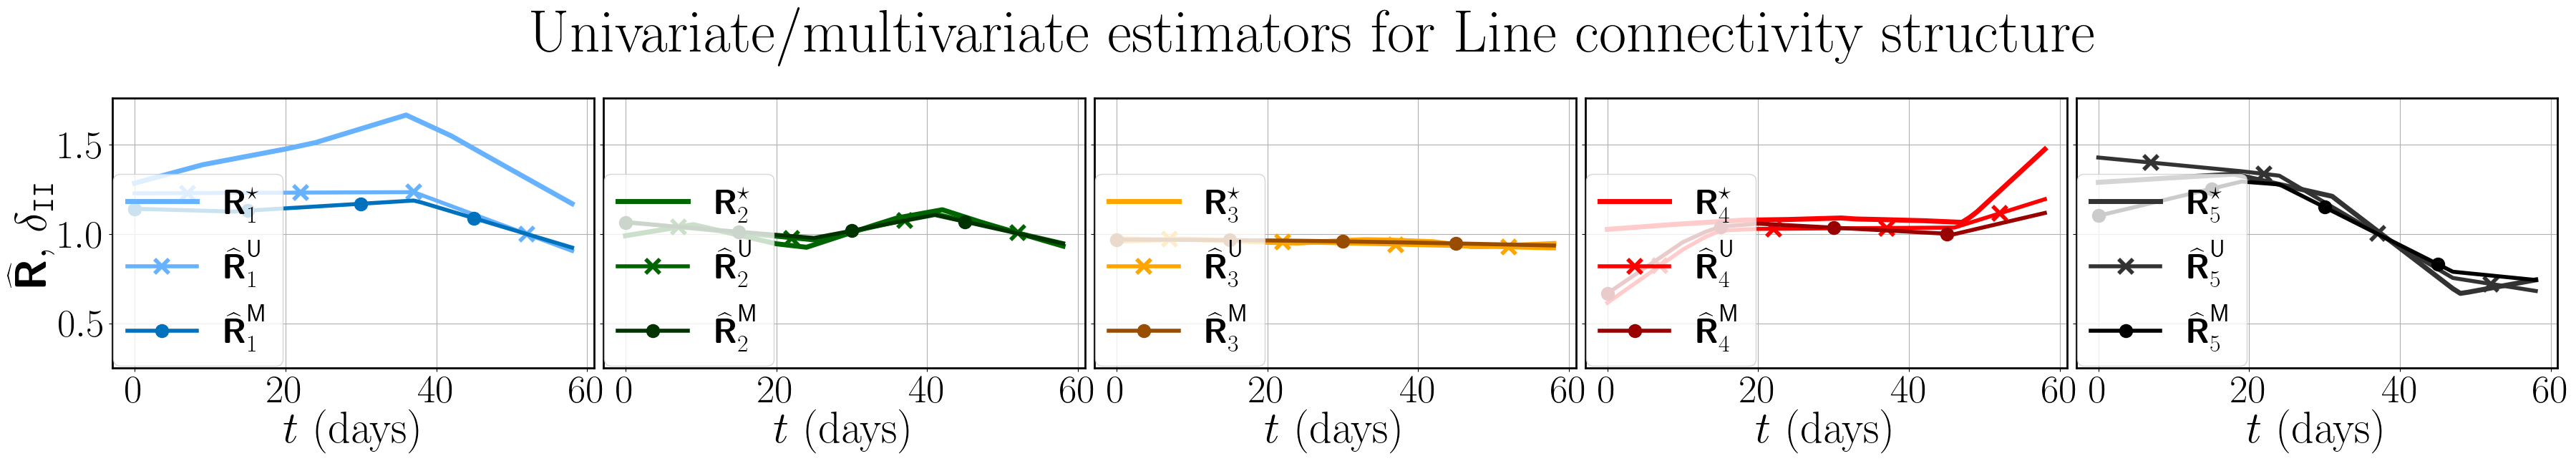

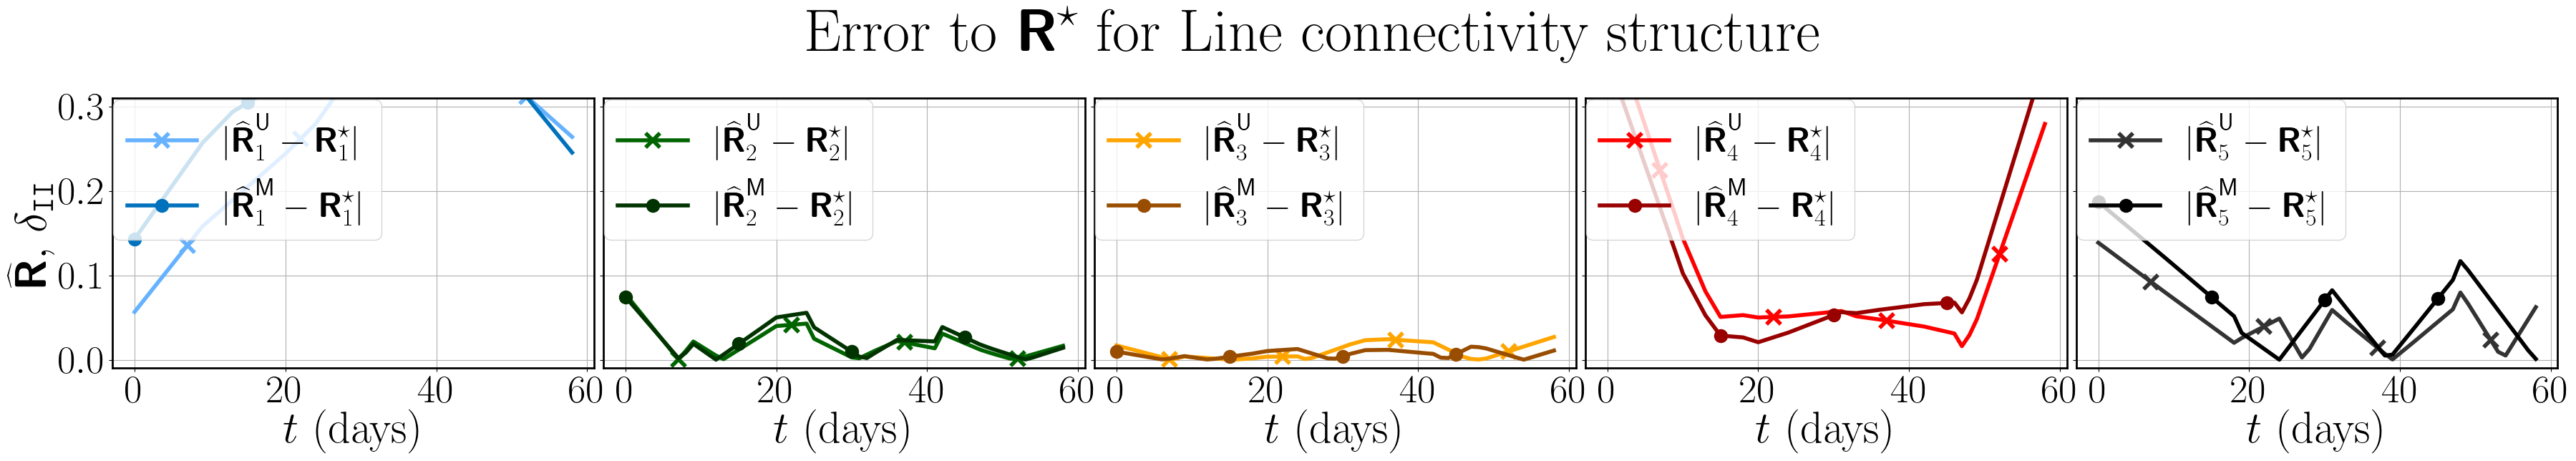

In [19]:
# Displaying comparison for chosen crafted infection counts, with chosen inter-county correlation level
display_comparison_uni_multi(connectStruct, configMulti, R_star, R_U_estim, R_M_estim)
display_comparison_error_uni_multi(connectStruct, configMulti, R_star, R_U_estim, R_M_estim)

In [69]:
optionsMulti["firstCases"]

array([206546.,   4856.,   6595.,  18900.,   2246.])